In [304]:
# Import Necessary Libraries

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal
import statsmodels.api as sm

from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
#from statsmodels.base.model import Vuong
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP




# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)
from kneed import KneeLocator

In [305]:
terr =  pd.read_csv('final_data.csv')

In [306]:
#other = pd.read_csv('LABED_dat.csv')

In [307]:
#df = pd.merge(terr,other[['eventid','label_3']],right_on='eventid' ,left_on='eventid',how='left')

In [308]:
#df=df.dropna(subset='label_3')

In [309]:
df=terr

In [310]:
#df['warzone'] = 0

In [311]:

rqmask = df['country_txt'] == 'Iraq'
smmask = df['country_txt'] == 'Somalia'
symask = df['country_txt'] == 'Syria'
yemnmask = df['country_txt'] == 'Yemen'

# Combine the masks with an 'or' condition
mask_to_drop = rqmask | smmask | symask | yemnmask

# Use the negation of the combined mask to keep rows where the mask is False
df = df[~mask_to_drop]
#df.loc[rqmask,'warzone'] = 1
#df.loc[smmask,'warzone'] = 1
#df.loc[symask,'warzone'] = 1"""

In [312]:
df=df[df['year']>=2000]

In [313]:
df['popGDP'] = df['GDP']/df['Population']

In [314]:
print(df.columns.to_list())

['Unnamed: 0', 'att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asi

In [315]:
df.drop(columns='Unnamed: 0',inplace=True)

In [316]:
df['weap_cbr'] = df['weap_Chemical'] + df['weap_Biological'] + df['weap_Radiological']

"""
df['letal'] = df['nkill'].apply(lambda x:1 if x !=0 else 0 )
df['weap_cbr'] = df['weap_Chemical'] + df['weap_Biological'] + df['weap_Radiological']
df['arm_mili'] = df['att_Armed Assault'] * df['targ_Military']
df['arm_poli'] = df['att_Armed Assault'] * df['targ_Police']
df['arm_citi'] = df['att_Armed Assault'] * df['targ_Private Citizens & Property']
df['sui_expl'] = df['suicide'] * df['weap_Explosives']
df['expl_asia'] = df['att_Bombing/Explosion'] * df['reg_Middle East & North Africa']
df['att_trasp'] = df['weap_Explosives'] * df['targ_Transportation']
df['warm_mili'] = df['weap_Firearms'] * df['targ_Military']
df['warm_poli'] = df['weap_Firearms'] * df['targ_Police']
df['warm_citi'] = df['weap_Firearms'] * df['targ_Private Citizens & Property']
"""

"\ndf['letal'] = df['nkill'].apply(lambda x:1 if x !=0 else 0 )\ndf['weap_cbr'] = df['weap_Chemical'] + df['weap_Biological'] + df['weap_Radiological']\ndf['arm_mili'] = df['att_Armed Assault'] * df['targ_Military']\ndf['arm_poli'] = df['att_Armed Assault'] * df['targ_Police']\ndf['arm_citi'] = df['att_Armed Assault'] * df['targ_Private Citizens & Property']\ndf['sui_expl'] = df['suicide'] * df['weap_Explosives']\ndf['expl_asia'] = df['att_Bombing/Explosion'] * df['reg_Middle East & North Africa']\ndf['att_trasp'] = df['weap_Explosives'] * df['targ_Transportation']\ndf['warm_mili'] = df['weap_Firearms'] * df['targ_Military']\ndf['warm_poli'] = df['weap_Firearms'] * df['targ_Police']\ndf['warm_citi'] = df['weap_Firearms'] * df['targ_Private Citizens & Property']\n"

In [317]:
df=df.drop(columns=['weap_Chemical','weap_Radiological'])

In [318]:
#bins = 100
#df = df[df['nkill']>0]
#df = df[df['nkill']<1000]

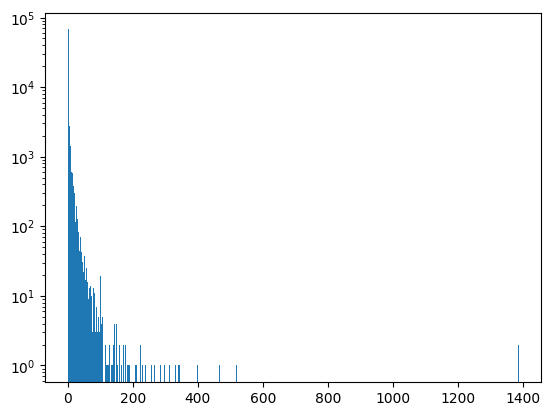

In [319]:
plt.hist(df['nkill'], bins=500)
plt.yscale('log')

In [320]:
positive_counts = df[df['nkill']>0]
positive_counts = positive_counts['nkill']

# Calculate mean and variance
mean_count = np.mean(positive_counts)
variance_count = np.var(positive_counts, ddof=1)  # ddof=1 for sample variance

print(f"Mean of positive counts: {mean_count}")
print(f"Variance of positive counts: {variance_count}")
# Print comparison
print("Comparison of mean and variance:")
print("Are the mean and variance approximately equal?", np.isclose(mean_count, variance_count, atol=10))

Mean of positive counts: 4.511848341232228
Variance of positive counts: 234.62240657589814
Comparison of mean and variance:
Are the mean and variance approximately equal? False


Elbow point at: 32


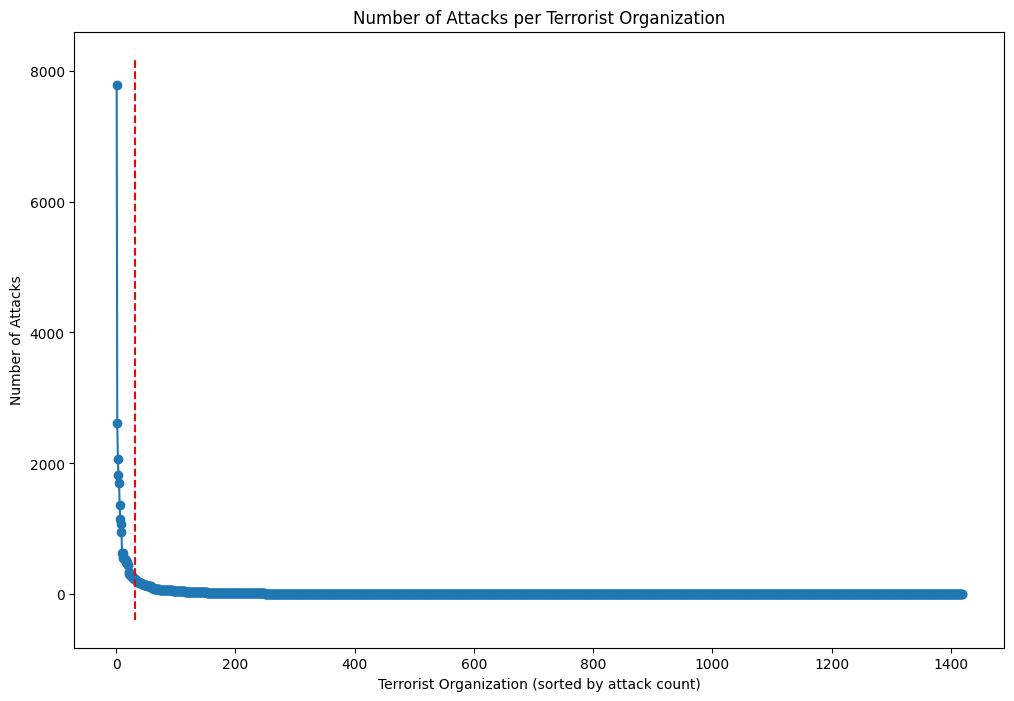

In [321]:
# Excluding 'Unknown'
df_filtered = df[df['gname'] != 'Unknown']

# Counting the number of attacks per organization
attacks_per_org = df_filtered['gname'].value_counts().sort_values(ascending=False)

# Converting to a format suitable for the Kneedle algorithm
# The Kneedle algorithm expects the data to be in a sorted order
x = range(1, len(attacks_per_org) + 1)
y = attacks_per_org.values

# Finding the elbow point
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

print(f"Elbow point at: {elbow_point}")

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='o', linestyle='-')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color = 'red')
plt.xlabel('Terrorist Organization (sorted by attack count)')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks per Terrorist Organization')

plt.show()

In [322]:
# identify the most common orgs
most_common_orgs = attacks_per_org.index.to_list()[:elbow_point]

# Modify the df['terrorist.org'] column
# Check if each value is in the most_common_orgs list, otherwise replace it with 'other'
df['gname'] = df['gname'].apply(lambda org: org if org in most_common_orgs else 'other')

In [323]:

to_dropp = ['country_txt','year','eventid','motive','success','n_weap','n_targ','weap_cbr']

Reasons to drop the values

nperps has too many missing values makiing the len 31k, const value 0.6

In [324]:

X = df.drop(columns=to_dropp)


In [325]:
data_cleaned = X.dropna(axis=0, how='any')

In [326]:
print(data_cleaned.columns.to_list())

['att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Midd

In [327]:
len(data_cleaned)

80116

In [328]:
data_cleaned

,att_Armed Assault,att_Assassination,att_Bombing/Explosion,att_Facility/Infrastructure Attack,att_Hijacking,att_Hostage Taking (Kidnapping),att_Unarmed Assault,weap_Biological,weap_Explosives,weap_Fake Weapons,...,v2clacfree,v2dlencmps,v2elembcap,v2exhoshog,Population,Net migration,Births from mothers aged 15 to 19 years,Population density,GDP,popGDP
57110,1,0,0,0,0,0,0,0,0,0,...,1.72500,0.85400,0.65000,1.00000,1819148.00000,5709.00000,8375.00000,2.20960,12211898000.00000,6712.97662
57111,0,0,0,0,0,1,0,0,0,0,...,1.72500,0.85400,0.65000,1.00000,1819148.00000,5709.00000,8375.00000,2.20960,12211898000.00000,6712.97662
57112,1,0,0,0,0,0,0,0,0,0,...,1.09000,1.22200,1.49900,0.00000,1059633660.00000,-149966.00000,5222965.00000,356.39620,2724476700000.00000,2571.14964
57115,0,0,1,0,0,0,0,0,1,0,...,1.09000,1.22200,1.49900,0.00000,1059633660.00000,-149966.00000,5222965.00000,356.39620,2724476700000.00000,2571.14964
57117,0,0,1,0,0,0,0,0,1,0,...,0.16900,-0.27800,1.94500,0.00000,64113548.00000,-77647.00000,168550.00000,83.30720,976023060000.00000,15223.35123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173447,0,0,0,0,0,1,0,0,0,0,...,1.23100,-1.13500,-0.78900,0.00000,92853170.00000,-1643.00000,527519.00000,40.95770,96945316000.00000,1044.07115
173449,0,0,0,1,0,0,0,0,0,0,...,1.33000,1.23400,0.87100,0.00000,29348626.00000,306664.00000,103669.00000,199.40500,110403750000.00000,3761.80302
173450,0,0,0,1,0,0,0,0,0,0,...,2.09800,2.16200,2.66900,0.00000,83328990.00000,334055.00000,13881.00000,239.06640,4311087000000.00000,51735.74047
173451,1,0,0,0,0,0,0,0,0,0,...,0.48700,0.20400,-0.09100,1.00000,38972236.00000,166821.00000,188016.00000,60.02230,76710640000.00000,1968.34074


In [329]:
y_cleaned = data_cleaned['nkill']
y_log_cleaned = np.log(data_cleaned['nkill'])
X_cleaned = data_cleaned.drop(columns=['nkill'])

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [330]:
X_encoded = pd.get_dummies(X_cleaned, columns=['gname'], drop_first=True).astype(int)

removing by coefficient

In [331]:
#X_encoded = X_encoded.drop(columns=

#'gname_Death Squad','gname_Mozambique National Resistance Movement (MNR)',"gname_People's Liberation Front (JVP)",'gname_Corsican National Liberation Front (FLNC)','gname_Hezbollah','gname_National Union for the Total Independence of Angola (UNITA)','gname_Protestant extremists',
#X_encoded = X_encoded.drop(columns=['weap_Fake Weapons', 'reg_Central America & Caribbean', 'multiple', 'v2exhoshog', 'gname_Revolutionary Armed Forces of Colombia (FARC)'])

#with warzones
#X_encoded = X_encoded.drop(columns=['gname_Sinai Province of the Islamic State','reg_Southeast Asia','weap_Incendiary', 'v2dlencmps', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Hamas (Islamic Resistance Movement)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_United Liberation Front of Assam (ULFA)','weap_Melee','weap_Other','reg_Central America & Caribbean','v2exhoshog','v2elembcap','v2clacfree','targ_Educational Institution'])


#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Armed Assault', 'att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Airports & Aircraft', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_East Asia', 'reg_Eastern Europe', 'reg_North America', 'reg_Southeast Asia', 'reg_Western Europe', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Al-Shabaab', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Islamic State of Iraq and the Levant (ISIL)', 'gname_Khorasan Chapter of the Islamic State', "gname_Kurdistan Workers' Party (PKK)", 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_National Liberation Army of Colombia (ELN)', "gname_New People's Army (NPA)", 'gname_Palestinian Extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Separatists', 'gname_Sinai Province of the Islamic State', 'gname_Taliban', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'targ_Government (Diplomatic)', 'targ_Other', 'reg_Eastern Europe', 'multiple', 'gname_Boko Haram', 'gname_Houthi extremists (Ansar Allah)', "gname_People's Liberation Front (JVP)","reg_Central America & Caribbean"])
#X_encoded = X_encoded.drop(columns=['att_Armed Assault', 'att_Hostage Taking (Barricade Incident)', 'weap_Melee', 'weap_Other', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Basque Fatherland and Freedom (ETA)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Farabundo Marti National Liberation Front (FMLN)', 'gname_Fulani extremists', 'gname_Houthi extremists (Ansar Allah)', 'gname_Irish Republican Army (IRA)', 'gname_Khorasan Chapter of the Islamic State', "gname_Kurdistan Workers' Party (PKK)", 'gname_Maoists', 'gname_Muslim extremists', 'gname_National Liberation Army of Colombia (ELN)', "gname_New People's Army (NPA)", 'gname_Nicaraguan Democratic Force (FDN)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Separatists', 'gname_Sikh Extremists', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)'])
#X_encoded = X_encoded.drop(columns=['targ_Food or Water Supply', 'reg_Southeast Asia', 'v2exhoshog', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Farabundo Marti National Liberation Front (FMLN)', 'gname_Irish Republican Army (IRA)', 'gname_Maoists', 'gname_Sinai Province of the Islamic State'])

In [332]:
#without warzone
#X_encoded = X_encoded.drop(columns=['gname_Sinai Province of the Islamic State','reg_Southeast Asia','weap_Incendiary', 'v2dlencmps', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Hamas (Islamic Resistance Movement)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_United Liberation Front of Assam (ULFA)','weap_Melee','weap_Other','reg_Central America & Caribbean','v2exhoshog','v2elembcap','v2clacfree','targ_Educational Institution'])

#with zeros
#X_encoded = X_encoded.drop(columns=['weap_Other', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_Southeast Asia', 'v2elembcap', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_United Liberation Front of Assam (ULFA)'])

#without zeros
#X_encoded = X_encoded.drop(columns=['weap_Fake Weapons', 'weap_Other', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Other', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'success', 'v2cldiscw', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Revolutionary Armed Forces of Colombia (FARC)','att_Hijacking', 'weap_Biological', 'weap_Chemical', 'weap_Melee', 'targ_Abortion Related', 'targ_NGO', 'reg_South America', 'INT_MISC', 'weap_cbr'])




In [333]:
#X_encoded = X_encoded.drop(columns=['weap_Fake Weapons', 'weap_Melee', 'weap_Other', 'targ_Abortion Related', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_NGO', 'targ_Other', 'reg_East Asia', 'reg_North America', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'INT_MISC', 'individual', 'multiple', 'success', 'v2cldiscw', 'v2clsnlpct', 'v2dlencmps', 'weap_cbr', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)'])

In [334]:
ssss = ['weap_Fake Weapons', 'weap_Other', 'targ_Abortion Related', 'targ_Business', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_NGO', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Southeast Asia', 'att2_Hostage Taking (Barricade Incident)', 'att2_Unknown', 'weap2_Chemical', 'weap2_Fake Weapons', 'weap2_Other', 'targ2_Educational Institution', 'targ2_Food or Water Supply', 'targ2_Maritime', 'targ2_NGO', 'targ2_Telecommunication', 'targ2_Unknown', 'targ2_Violent Political Party', 'nperpcap', 'v2exhoshog', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Al-Qaida in the Islamic Maghreb (AQIM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Hizbul Mujahideen (HM)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_Taliban', 'gname_United Liberation Front of Assam (ULFA)']


In [335]:
#filtered on removing zeros

#X_encoded = X_encoded.drop(columns=ssss)

In [336]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

In [337]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [338]:
print(to_drop)


['weap_Explosives']


In [339]:
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [340]:
#X_encoded_final = X_encoded_var_filtered

In [341]:
#X_encoded_final['tal_asia'] = X_encoded_final['gname_Taliban']*X_encoded_final['reg_South Asia']

In [342]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

In [343]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

In [344]:

#madress = ['att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'weap_Other', 'weap_Sabotage Equipment',  'targ_Aircraft (not at an airport)', 'targ_Airline Officer/Personnel', 'targ_Airport', 'targ_Ambulance', 'targ_Bus Station/Stop', 'targ_Clinics', 'targ_Commercial Maritime', 'targ_Electricity', 'targ_Farmer', 'targ_Fire Fighter/Truck', 'targ_Food Supply', 'targ_Gas', 'targ_Highway/Road/Toll/Traffic Signal', 'targ_Hotel/Resort', 'targ_Industrial/Textiles/Factory', 'targ_Internet Infrastructure', 'targ_Memorial/Cemetery/Monument', 'targ_Military Checkpoint', 'targ_Military Maritime', 'targ_Military Personnel (soldiers, troops, officers, forces)', 'targ_Military Unit/Patrol/Convoy', 'targ_Military Weaponry', 'targ_Mining', 'targ_Multinational Corporation', 'targ_Multiple Telecommunication Targets', 'targ_Oil', 'targ_Oil Tanker', 'targ_Other Facility', 'targ_Party Office/Facility', 'targ_Personnel', 'targ_Police Building (headquarters, station, school)', 'targ_Police Checkpoint', 'targ_Port', 'targ_Prison/Jail', 'targ_Protester', 'targ_Public Area (garden, parking lot, garage, beach, public building, camp)', 'targ_Radio', 'targ_Rally', 'targ_Refugee (including Camps/IDP/Asylum Seekers)', 'targ_Religion Identified', 'targ_Restaurant/Bar/Café', 'targ_Royalty', 'targ_Television', 'targ_Terrorist', 'targ_Tour Bus/Van', 'targ_Tourism Travel Agency', 'targ_Tourist', 'targ_Unnamed Civilian/Unspecified', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'individual', 'multiple', 'v2cldiscw', 'v2dlencmps', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)']

#madress += ['att_Facility/Infrastructure Attack','targ_Taxi/Rickshaw','targ_School/University/Educational Building','weap_Incendiary']

#madress = ['att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Unarmed Assault', 'weap_Automatic or Semi-Automatic Rifle', 'weap_Explosive', 'weap_Gasoline or Alcohol', 'weap_Letter Bomb', 'weap_Other Gun Type', 'weap_Pipe Bomb', 'weap_Poisoning', 'weap_Pressure Trigger', 'targ_Airport', 'targ_Ambulance', 'targ_Bank/Commerce', 'targ_Bridge/Car Tunnel', 'targ_Bus Station/Stop', 'targ_Clinics', 'targ_Commercial Maritime', 'targ_Domestic NGO', 'targ_Electricity', 'targ_Farm/Ranch', 'targ_Farmer', 'targ_Fire Fighter/Truck', 'targ_Food Supply', 'targ_Gas/Oil/Electric', 'targ_Highway/Road/Toll/Traffic Signal', 'targ_Hotel/Resort', 'targ_Labor Union Related', 'targ_Legal Services', 'targ_Medical/Pharmaceutical', 'targ_Memorial/Cemetery/Monument', 'targ_Military Barracks/Base/Headquarters/Checkpost', 'targ_Military Maritime', 'targ_Military Personnel (soldiers, troops, officers, forces)', 'targ_Military Weaponry', 'targ_Oil', 'targ_Oil Tanker', 'targ_Other (including online news agencies)', 'targ_Other Facility', 'targ_Political Party Member/Rally', 'targ_Port', 'targ_Prison/Jail', 'targ_Private Security Company/Firm', 'targ_Protester', 'targ_Public Area (garden, parking lot, garage, beach, public building, camp)', 'targ_Refugee (including Camps/IDP/Asylum Seekers)', 'targ_Restaurant/Bar/Café', 'targ_Royalty', 'targ_School/University/Educational Building', 'targ_Student', 'targ_Taxi/Rickshaw', 'targ_Terrorist', 'targ_Tour Bus/Van', 'targ_Tourism Travel Agency', 'targ_Tourist', 'targ_Unnamed Civilian/Unspecified', 'targ_Vehicles/Transportation', 'targ_Village/City/Town/Suburb', 'targ_Water Supply', 'reg_Central America & Caribbean', 'reg_East Asia', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'individual', 'vicinity', 'v2x_ex_military', 'v2cldiscw', 'v2clacfree', 'v2elembcap', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State']

#madress += ['targ_Multinational Corporation', 'v2exhoshog', 'Population', 'gname_Al-Shabaab', 'gname_Fulani extremists', 'gname_Separatists']

#madress = ['gname_Tehrik-i-Taliban Pakistan (TTP)','att_Facility/Infrastructure Attack', 'att_Unarmed Assault', 'weap_Explosive', 'weap_Gasoline or Alcohol', 'weap_Landmine', 'weap_Letter Bomb', 'weap_Other Gun Type', 'weap_Pipe Bomb', 'weap_Unknown Explosive Type', 'weap_Unknown Weapon Type', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'individual', 'multiple', 'claimed', 'v2cldiscw', 'Net migration', 'gname_Boko Haram', 'gname_Houthi extremists (Ansar Allah)', 'gname_Revolutionary Armed Forces of Colombia (FARC)']

#madress =[ 'weap_Chemical', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Sabotage Equipment', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Telecommunication', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_Southeast Asia', 'vicinity', 'claimed', 'nperpcap', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Al-Qaida in the Islamic Maghreb (AQIM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Hizbul Mujahideen (HM)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)']

#madress_0 = ['att_Facility/Infrastructure Attack', 'weap_Explosives', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Sabotage Equipment', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_East Asia', 'reg_Eastern Europe', 'reg_North America', 'reg_South America', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'v2cldiscw', 'Net migration', 'gname_Boko Haram', 'gname_Houthi extremists (Ansar Allah)', 'gname_Revolutionary Armed Forces of Colombia (FARC)']


madress_0 = ['v2dlencmps', 'weap_Fake Weapons', 'weap_Other', 'targ_Abortion Related', 'targ_Business', 'targ_Government (General)', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_Southeast Asia', 'vicinity', 'claimed', 'nperpcap', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Al-Qaida in the Islamic Maghreb (AQIM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Hizbul Mujahideen (HM)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)']

madress_0 +=  ['weap2_Fake Weapons', 
 'weap2_Other', 
 'targ2_Business', 
 'targ2_Government (General)', 
 'targ2_Terrorists/Non-State Militia', 
 'targ2_Tourists', 
 'targ2_Violent Political Party']

madress_0 +=['weap3_Fake Weapons', 
 'weap3_Other', 
 'targ3_Business', 
 'targ3_Government (General)', 
 'targ3_Terrorists/Non-State Militia', 
 'targ3_Tourists', 
 'targ3_Violent Political Party']

madress_0+=['weap4_Fake Weapons', 
 'weap4_Other']



ssssss_5 = ['weap_Incendiary', 'att3_Assassination', 'att3_Hostage Taking (Barricade Incident)', 'weap2_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'weap3_Sabotage Equipment', 'weap3_Unknown', 'weap3_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'weap4_Firearms', 'targ2_Government (General)', 'targ2_Religious Figures/Institutions', 'targ3_Business', 'targ3_Educational Institution', 'targ3_Maritime', 'targ3_NGO', 'targ3_Other', 'targ3_Police', 'targ3_Religious Figures/Institutions', 'targ3_Telecommunication', 'targ3_Transportation', 'targ3_Utilities', 'targ3_Violent Political Party', 'vicinity', 'claimed', 'v2clacfree', 'v2dlencmps', "gname_Donetsk People's Republic"]

ssss_4 = [ 'weap_Incendiary', 'att3_Hostage Taking (Barricade Incident)', 'att3_Unknown', 'weap3_Chemical', 'weap3_Fake Weapons', 'weap3_Other', 'targ2_Religious Figures/Institutions', 'targ3_Educational Institution', 'targ3_Food or Water Supply', 'targ3_Maritime', 'targ3_NGO', 'targ3_Unknown', 'targ3_Violent Political Party', 'vicinity', 'claimed', 'v2dlencmps', "gname_Donetsk People's Republic"]

In [345]:
ssssss_5 += ['weap_Fake Weapons', 'targ_Abortion Related', 'targ_Business', 'targ_Government (General)', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_Southeast Asia', 'att2_Hostage Taking (Barricade Incident)', 'att2_Unknown', 'weap2_Chemical', 'weap2_Fake Weapons', 'weap2_Other', 'targ2_Educational Institution', 'targ2_Food or Water Supply', 'targ2_Maritime', 'targ2_NGO', 'targ2_Unknown', 'targ2_Violent Political Party', 'nperpcap', 'Net migration', 'gname_Al-Qaida in the Islamic Maghreb (AQIM)', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_United Liberation Front of Assam (ULFA)']

ssssss_5 += ['att2_Assassination', 'att3_Bombing/Explosion', 'weap3_Other', 'targ3_Government (General)', 'v2exhoshog', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Sinai Province of the Islamic State']
ssssss_5 += ['gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)']
ssssss_5 += ['att_Armed Assault', 'weap_Other', 'targ3_Government (Diplomatic)', 'targ3_Terrorists/Non-State Militia']

#hi, this is for all of them inside 

In [346]:
ssssss_6 = ['weap_Incendiary', 'att3_Assassination', 'att3_Hostage Taking (Barricade Incident)', 'weap2_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'weap3_Sabotage Equipment', 'weap3_Unknown', 'weap3_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'weap4_Firearms', 'targ2_Government (General)', 'targ2_Religious Figures/Institutions', 'targ3_Business', 'targ3_Educational Institution', 'targ3_Maritime', 'targ3_NGO', 'targ3_Other', 'targ3_Police', 'targ3_Religious Figures/Institutions', 'targ3_Telecommunication', 'targ3_Transportation', 'targ3_Utilities', 'targ3_Violent Political Party', 'vicinity', 'claimed', 'v2clacfree', 'v2dlencmps', "gname_Donetsk People's Republic"]

ssssss_6 += ['weap_Fake Weapons', 'targ_Abortion Related', 'targ_Business', 'targ_Military', 'targ_Police', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_Eastern Europe', 'reg_North America', 'reg_South America', 'reg_Southeast Asia', 'att2_Assassination', 'att2_Hostage Taking (Barricade Incident)', 'att2_Unknown', 'att3_Bombing/Explosion', 'att3_Facility/Infrastructure Attack', 'weap2_Chemical', 'weap2_Fake Weapons', 'weap2_Other', 'weap2_Sabotage Equipment', 'weap3_Other', 'targ2_Educational Institution', 'targ2_Journalists & Media', 'targ2_Maritime', 'targ2_Telecommunication', 'targ2_Unknown', 'targ2_Violent Political Party', 'targ3_Food or Water Supply', 'targ3_Journalists & Media', 'nperpcap', 'v2elembcap', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Taliban', 'gname_Tehrik-i-Taliban Pakistan (TTP)']

# without zeros

In [347]:
print(X_encoded_with_const.columns.to_list())

['const', 'att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_Central Asia', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Middle East & 

In [348]:
ssss_56 = ['weap_Explosives', 'targ_Business', 'targ_Educational Institution', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Transportation', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North America', 'reg_South America', 'reg_South Asia', 'reg_Southeast Asia', 'reg_Sub-Saharan Africa', 'reg_Western Europe', 'n_att', 'v2cldiscw', 'v2clacfree', 'Population', 'gname_Maoists', 'gname_Taliban', 'gname_other']
ssss_56 += ['targ2_Violent Political Party', 'targ3_Transportation','att_Armed Assault', 'gname_Palestinian Extremists']
ssss_56 += ['weap_Fake Weapons', 'weap_Incendiary', 'weap_Other', 'targ_Abortion Related', 'targ_Food or Water Supply', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'att2_Hijacking', 'att2_Hostage Taking (Barricade Incident)', 'att2_Unarmed Assault', 'att3_Hostage Taking (Kidnapping)', 'weap2_Chemical', 'weap2_Fake Weapons', 'weap2_Other', 'weap2_Sabotage Equipment', 'weap3_Explosives', 'weap3_Melee', 'weap3_Sabotage Equipment', 'weap3_Unknown', 'weap3_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ2_Airports & Aircraft', 'targ2_Educational Institution', 'targ2_Government (Diplomatic)', 'targ2_Maritime', 'targ2_Military', 'targ2_NGO', 'targ2_Police', 'targ2_Religious Figures/Institutions', 'targ2_Telecommunication', 'targ2_Terrorists/Non-State Militia', 'targ2_Tourists', 'targ3_Business', 'targ3_Government (Diplomatic)', 'targ3_NGO', 'targ3_Private Citizens & Property', 'targ3_Telecommunication', 'targ3_Tourists', 'multiple', 'v2x_ex_military', 'gname_Anarchists', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Tehrik-i-Taliban Pakistan (TTP)']

In [349]:
X_encoded_with_const = X_encoded_with_const.drop(columns=ssssss_5)

In [350]:
""""

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming `X_encoded_with_const` is your feature matrix
vif_data = pd.DataFrame()
vif_data['Feature'] = X_encoded_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_encoded_with_const.values, i) for i in range(X_encoded_with_const.shape[1])]

mask = vif_data['VIF']>=5

print(vif_data.loc[mask,'Feature'].to_list())"""


'"\n\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\n# Assuming `X_encoded_with_const` is your feature matrix\nvif_data = pd.DataFrame()\nvif_data[\'Feature\'] = X_encoded_with_const.columns\nvif_data[\'VIF\'] = [variance_inflation_factor(X_encoded_with_const.values, i) for i in range(X_encoded_with_const.shape[1])]\n\nmask = vif_data[\'VIF\']>=5\n\nprint(vif_data.loc[mask,\'Feature\'].to_list())'

In [351]:
model_nb = NegativeBinomial(y_cleaned, X_encoded_with_const).fit(maxiter=1000)

print(model_nb.summary())

Optimization terminated successfully.
         Current function value: 1.543775
         Iterations: 38
         Function evaluations: 42
         Gradient evaluations: 42
                     NegativeBinomial Regression Results                      
Dep. Variable:                  nkill   No. Observations:                80116
Model:               NegativeBinomial   Df Residuals:                    80016
Method:                           MLE   Df Model:                           99
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.1251
Time:                        15:55:05   Log-Likelihood:            -1.2368e+05
converged:                       True   LL-Null:                   -1.4137e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

In [352]:
results_summary = pd.DataFrame({
    'params': model_nb.params,
    'pvalues': model_nb.pvalues
})

# Find the parameters where the p-value is greater than 0.05
high_pvalue_params = results_summary[results_summary['pvalues'] > 0.05].index.tolist()

print("Parameters with p-value above 0.05:", high_pvalue_params)

Parameters with p-value above 0.05: ['weap_Biological', 'reg_South America', 'GDP', 'gname_Boko Haram']


In [353]:
""""
zinb_model = ZeroInflatedNegativeBinomialP(y_cleaned, X_encoded_with_const, exog_infl=X_encoded_with_const)
zinb_results = zinb_model.fit(maxiter=10,disp=True)
print(zinb_results.summary())"""



'"\nzinb_model = ZeroInflatedNegativeBinomialP(y_cleaned, X_encoded_with_const, exog_infl=X_encoded_with_const)\nzinb_results = zinb_model.fit(maxiter=10,disp=True)\nprint(zinb_results.summary())'

In [354]:
X_encoded_with_const.to_csv('big_X.csv')

In [355]:
y_cleaned.to_csv('big_y.csv')

In [356]:
X = X_encoded_with_const  
y = y_cleaned


In [357]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation


In [358]:
rmse_scores = []
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the Negative Binomial model on the training data
    nb_model = NegativeBinomial(y_train, X_train)
    nb_results = nb_model.fit(disp=0,maxiter=100)  # Set disp=0 to turn off verbose output
    
    # Predict on the testing set
    y_pred = nb_results.predict(X_test)
    
    # Calculate the root mean squared error and store
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Calculate average RMSE over all folds
average_rmse = np.mean(rmse_scores)
print(f'Average RMSE across all folds: {average_rmse}')


Average RMSE across all folds: 11.503780913266388


In [359]:
intercept = 0.3020
coef_armed_assault = 0.2291
coef_suicide = 0.3371

# Calculate the log-expected count (log scale prediction)
log_lambda = intercept  + coef_armed_assault + coef_suicide

# Convert log scale prediction to the original count scale (expected number of kills)
expected_kills = np.exp(log_lambda)

print(f"Expected number of fatalities in a terrorist attack with an armed assault and a suicide attack: {expected_kills:.2f}")
from scipy.stats import nbinom

# Number of deaths for which to calculate the probability
deaths = 2

# The parameters of the Negative Binomial distribution
r = np.exp(intercept)  # or other baseline count depending on the model setup
p = 1 / (1 + expected_kills)

# Calculate the probability of exactly 'deaths' deaths
probability = nbinom.pmf(deaths, r, p)
print(f"Probability of exactly {deaths} deaths: {probability:.4f}")


Expected number of fatalities in a terrorist attack with an armed assault and a suicide attack: 2.38
Probability of exactly 2 deaths: 0.1519


In [360]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

C:\Users\lucab\AppData\Local\Temp\ipykernel_31408\453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  nkill   No. Observations:                80116
Model:                            GLM   Df Residuals:                    80016
Model Family:                 Poisson   Df Model:                           99
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3249e+05
Date:                Tue, 07 May 2024   Deviance:                   3.5688e+05
Time:                        15:55:40   Pearson chi2:                 1.19e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9439
Covariance Type:            nonrobust                                         
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [361]:
results_summary = pd.DataFrame({
    'params': model.params,
    'pvalues': model.pvalues
})

# Find the parameters where the p-value is greater than 0.05
high_pvalue_params = results_summary[results_summary['pvalues'] > 0.05].index.tolist()

print("Parameters with p-value above 0.05:", high_pvalue_params)

Parameters with p-value above 0.05: ['weap_Biological']


In [362]:


# Define the intercept and coefficients for the relevant predictors
intercept = 0.3560
coef_military = 0.4434  # Coefficient for targeting the military
coef_armed_assault = -0.0714  # Coefficient for armed assault
suis = 0.3446

# Calculate the log-expected count (log scale prediction)
log_lambda = intercept + coef_military + coef_armed_assault + suis

# Convert log scale prediction to the original count scale (expected number of kills)
expected_kills = np.exp(log_lambda)

print(f"Expected number of fatalities in a terrorist attack targeting the military with an armed assault: {expected_kills:.2f}")


Expected number of fatalities in a terrorist attack targeting the military with an armed assault: 2.92


In [363]:
# extract and plot regression coefficients 
beta_mean = model_nb.params
beta_cov = model_nb.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)
#simulated_betas = multivariate_normal.rvs(mean=beta_mean[:-1], cov=beta_cov[:-1,:-1], size=n_simulations)

simulations_df = pd.DataFrame(model_nb.params)
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

In [364]:
tresholdd=0.01

In [365]:
mask=simulations_df<tresholdd
ggg=simulations_df[mask]
mask2 = ggg>-tresholdd
gg44=ggg[mask2]
lista = gg44.dropna()
print(lista.index.to_list())

['weap_Biological', 'reg_South America']


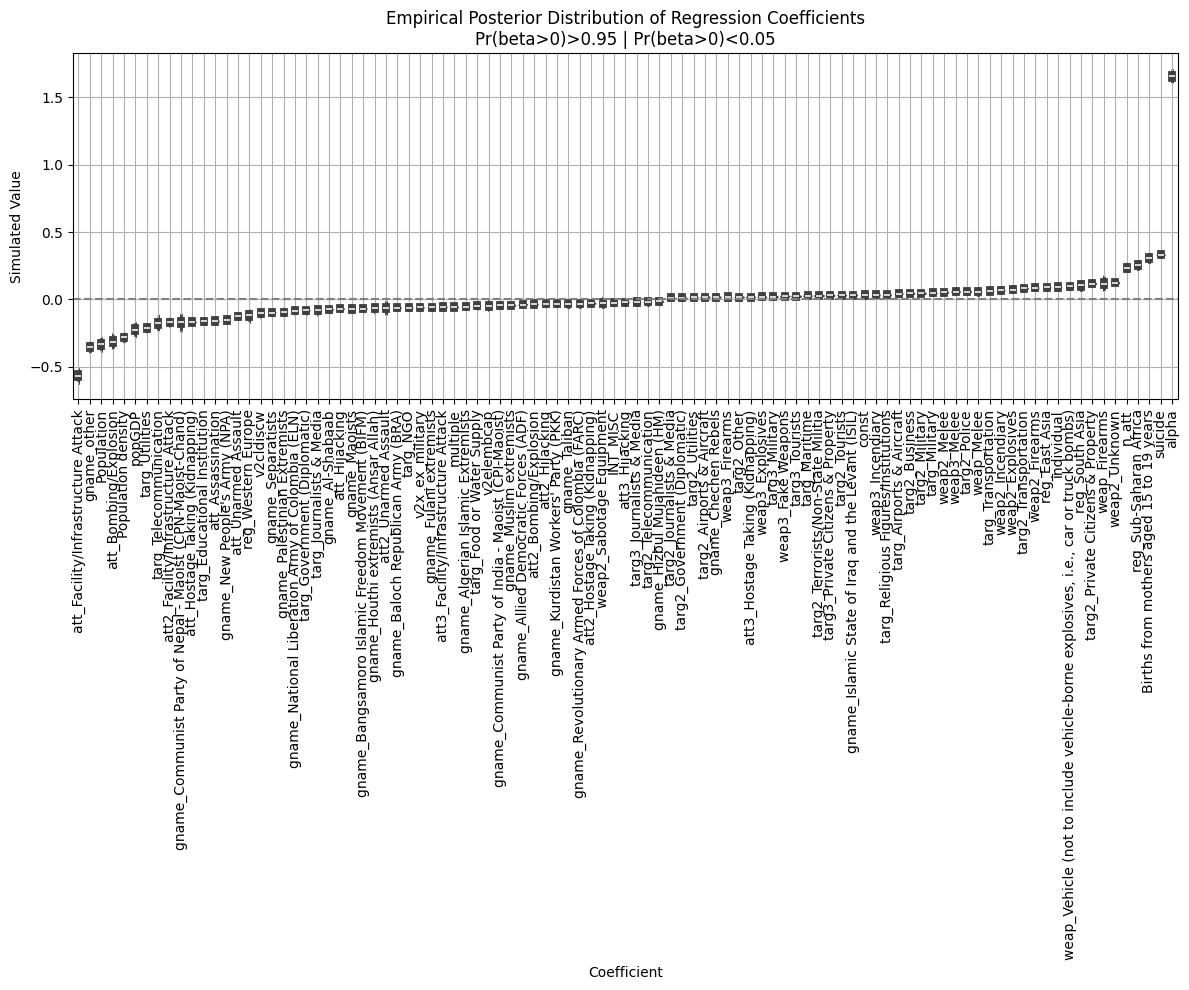

In [366]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model_nb.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [367]:
fff=X_encoded_with_const

In [368]:
fff.shape[0]

80116

In [369]:

predicted_counts = np.zeros((n_simulations, fff.shape[0]))


In [370]:
""""import numpy as np
import pandas as pd
from scipy.stats import nbinom

# Assuming `fff` is your feature matrix and `n_simulations` is defined
# Example data for `simulated_betas` and `dispersion_parameter_r`
simulated_betas = [np.random.normal(size=fff.shape[1]) for _ in range(n_simulations)]  # example beta coefficients
dispersion_parameter_r = 1.5  # This should ideally come from your model

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(fff, beta_simulation))  # Mean number of events (lambda)
    
    # For Negative Binomial, we need to calculate `p` (success probability)
    # Using the parameterization p = r / (r + mean) where mean is `predicted_rate`
    p = dispersion_parameter_r / (dispersion_parameter_r + predicted_rate)
    
    # Generate random outcomes from a negative binomial distribution
    predicted_counts[i] = nbinom.rvs(dispersion_parameter_r, p)

print(predicted_counts)
"""

'"import numpy as np\nimport pandas as pd\nfrom scipy.stats import nbinom\n\n# Assuming `fff` is your feature matrix and `n_simulations` is defined\n# Example data for `simulated_betas` and `dispersion_parameter_r`\nsimulated_betas = [np.random.normal(size=fff.shape[1]) for _ in range(n_simulations)]  # example beta coefficients\ndispersion_parameter_r = 1.5  # This should ideally come from your model\n\n# Generate predictions for each simulation\nfor i in range(n_simulations):\n    beta_simulation = simulated_betas[i]\n    predicted_rate = np.exp(np.dot(fff, beta_simulation))  # Mean number of events (lambda)\n    \n    # For Negative Binomial, we need to calculate `p` (success probability)\n    # Using the parameterization p = r / (r + mean) where mean is `predicted_rate`\n    p = dispersion_parameter_r / (dispersion_parameter_r + predicted_rate)\n    \n    # Generate random outcomes from a negative binomial distribution\n    predicted_counts[i] = nbinom.rvs(dispersion_parameter_r, p

In [371]:
"""
from scipy.stats import nbinom,poisson
from sklearn.metrics import mean_squared_error


# Generate predicted counts using the NB model
predicted_counts = []
for beta_simulation in simulated_betas:
    mean_predicted_rate = np.exp(np.dot(fff, beta_simulation[:-1]))   # log-linear model prediction   
    p = 1 / (1 + mean_predicted_rate * r)  # convert mean rate to probability for NB
    predicted_counts.append(poisson.rvs(mean_predicted_rate))  # simulate from NB

predicted_counts = np.array(predicted_counts)
monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

print(f'Correlation: {correlation:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Bias: {bias:.2f}')
print(f'Coverage: {coverage:.2%}')
"""

Correlation: 0.20
RMSE: 11.55
Bias: 0.12
Coverage: 87.96%


In [372]:
from scipy.stats import nbinom
from sklearn.metrics import mean_squared_error
r=1.7


# Generate predicted counts using the NB model
predicted_counts = []
for beta_simulation in simulated_betas:
    mean_predicted_rate = np.exp(np.dot(fff, beta_simulation[:-1]))  # log-linear model prediction     must consider without the aplha value
    p = 1 / (1 + mean_predicted_rate * r)  # convert mean rate to probability for NB
    predicted_counts.append(nbinom.rvs(r, p))  # simulate from NB

predicted_counts = np.array(predicted_counts)
monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

print(f'Correlation: {correlation:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Bias: {bias:.2f}')
print(f'Coverage: {coverage:.2%}')


Correlation: 0.20
RMSE: 17.21
Bias: 3.48
Coverage: 96.09%


In [373]:
""""# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(fff, beta_simulation))
    print(predicted_rate)
    predicted_counts[i] = np.random.poisson(predicted_rate)"""

'"# Generate predictions for each simulation\nfor i in range(n_simulations):\n    beta_simulation = simulated_betas[i]\n    predicted_rate = np.exp(np.dot(fff, beta_simulation))\n    print(predicted_rate)\n    predicted_counts[i] = np.random.poisson(predicted_rate)'

In [374]:
predicted_counts

array([[10,  3, 19, ...,  0,  4, 26],
       [ 3,  1, 23, ...,  0, 13, 22],
       [11,  3,  5, ...,  0,  6,  4],
       ...,
       [ 8,  4, 16, ...,  0,  0, 15],
       [17,  9,  1, ...,  0,  4, 13],
       [18,  3, 14, ...,  0,  0,  6]], dtype=int64)

In [375]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

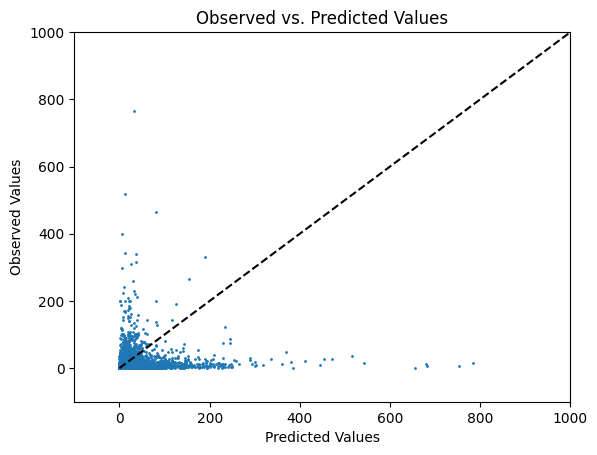

In [378]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
#errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')
""""
# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='upper right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)
"""
plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.xlim(-100, 1000)
plt.ylim(-100,1000)
plt.show()